In [50]:
from textblob import TextBlob
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Lasso, LogisticRegression
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np
import praw
import pdb
import warnings
warnings.filterwarnings("ignore")

In [17]:
clientID = 'VpVEXRwC5-nrbA'
clientSecret = 'XMql3JHOqhq2NatetFMFPkhBaCE'
userAgent = 'Reddit WebScraping'
reddit = praw.Reddit(client_id=clientID, client_secret=clientSecret, user_agent=userAgent)

In [ ]:
# Retrieve the top (most upvoted) 1k posts in the last year and add them to a Pandas dataframe
topPosts = []
subReddit = reddit.subreddit('all')
for post in tqdm(subReddit.top(time_filter = 'year', limit=1000), total=1000):
    topPosts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created_utc, post.author, post.is_self, post.over_18, post.spoiler, post.upvote_ratio])
    
topPosts = pd.DataFrame(topPosts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created', 'author', 'is_self', 'over_18', 'spoiler', 'upvote_ratio'])
topPosts.to_csv("top1KPosts.csv", index=False)

In [ ]:
# Retrieve the most controversial (most downvoted) 1k posts in the last year and add them to a Pandas dataframe
controvertialPosts = []
subReddit = reddit.subreddit('all')
for post in tqdm(subReddit.controversial(time_filter = 'year', limit=1000), total=1000):
    controvertialPosts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, post.created_utc, post.author, post.is_self, post.over_18, post.spoiler, post.upvote_ratio])
controvertialPosts = pd.DataFrame(controvertialPosts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created', 'author', 'is_self', 'over_18', 'spoiler', 'upvote_ratio'])
controvertialPosts.to_csv("controvertial1KPosts.csv", index=False)

In [51]:
top1KPosts = pd.read_csv("top1kPosts.csv")
controversial1KPosts = pd.read_csv("controversial1kPosts.csv")

To avoid calling the Reddit API thousands of times, we have saved the results of 1k "Top" posts and 1k "Controversial" posts to a data frame. For all future analysis, we will be reading and modifying these data frames. 

In [128]:
topSubReddit = top1KPosts.subreddit.unique() # List of subreddits that have broken top 10k
topSubReddit[0:10]

array(['pics', 'gaming', 'AskReddit', 'Showerthoughts', 'news', 'memes',
       'funny', 'YouFellForItFool', 'aww', 'videos'], dtype=object)

In [129]:
controversialSubReddits = controversial1KPosts.subreddit.unique() # List of subreddits that have broken most controversial 10k
controversialSubReddits[0:10]

array(['motorcycles', 'unpopularopinion', 'IAmA', 'AmItheAsshole',
       'TheMonkeysPaw', 'TrueOffMyChest', 'gadgets', 'leagueoflegends',
       'DestinyTheGame', 'FortNiteBR'], dtype=object)

In [130]:
for tableRow in top1KPosts.iterrows():
     top1KPosts.at[tableRow[0], "post_type"] = 1

for tableRow in controversial1KPosts.iterrows():
    controversial1KPosts.at[tableRow[0], "post_type"] = 0

dataSet = pd.concat([top1KPosts, controversial1KPosts])
dataSet = dataSet.reset_index()
dataSet = dataSet.drop(["index", "id", "url", "created", "author"], axis=1)
dataSet.head()

,title,score,subreddit,num_comments,body,is_self,over_18,spoiler,upvote_ratio,post_type
0,Given that reddit just took a $150 million inv...,228918,pics,6491,NaN,False,False,False,0.94,1.0
1,I got off the horse by accident right before a...,226498,gaming,2238,NaN,False,False,False,0.97,1.0
2,"Take your time, you got this",224055,gaming,3360,NaN,False,False,False,0.97,1.0
3,"People who haven't pooped in 2019 yet, why are...",221862,AskReddit,8132,NaN,True,False,False,0.91,1.0
4,Whoever created the tradition of not seeing th...,218614,Showerthoughts,2098,Damn... this got big...,True,False,False,0.96,1.0


In [131]:
uniqueSubReddits = {"subReddit" : []}

for tableRow in dataSet.iterrows():
    title = tableRow[1]["title"]
    subReddit = tableRow[1]["subreddit"]
    body = tableRow[1]["body"]

    originalContent = tableRow[1]["is_self"]
    nsfw = tableRow[1]["over_18"]
    spoiler = tableRow[1]["spoiler"]

    titleBlob = TextBlob(title)

    lenTitle = len(title)
    titleSentiment = titleBlob.sentiment.polarity
    titleSubjectivity = titleBlob.sentiment.subjectivity

    if subReddit not in uniqueSubReddits["subReddit"]:
        uniqueSubReddits["subReddit"].append(subReddit)

    lenBody = 0
    try:
        if np.isnan(body):
            body = ""
            lenBody = 0
    except:
        lenBody = len(body)

    dataSet.at[tableRow[0], "len_title"] = lenTitle
    dataSet.at[tableRow[0], "title_sentiment"] = titleSentiment
    dataSet.at[tableRow[0], "title_subjectivity"] = titleSubjectivity
    dataSet.at[tableRow[0], "body"] = body
    dataSet.at[tableRow[0], "len_body"] = lenBody
    
    dataSet.at[tableRow[0], "is_oc"] = 0
    if originalContent:
        dataSet.at[tableRow[0], "is_oc"] = 1


    dataSet.at[tableRow[0], "is_nsfw"] = 0
    if nsfw:
        dataSet.at[tableRow[0], "is_nsfw"] = 1

    dataSet.at[tableRow[0], "is_spoiler"] = 0
    if spoiler:
        dataSet.at[tableRow[0], "is_spoiler"] = 1

dataSet = dataSet.drop(["is_self", "over_18", "spoiler",], axis=1)
subRedditLookUp = pd.DataFrame(uniqueSubReddits)
subRedditOneHotEncoding = pd.get_dummies(subRedditLookUp)
dataSet.head()

,title,score,subreddit,num_comments,body,upvote_ratio,post_type,len_title,title_sentiment,title_subjectivity,len_body,is_oc,is_nsfw,is_spoiler
0,Given that reddit just took a $150 million inv...,228918,pics,6491,,0.94,1.0,241.0,0.245455,0.484848,0.0,0.0,0.0,0.0
1,I got off the horse by accident right before a...,226498,gaming,2238,,0.97,1.0,67.0,0.028571,0.311905,0.0,0.0,0.0,0.0
2,"Take your time, you got this",224055,gaming,3360,,0.97,1.0,28.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,"People who haven't pooped in 2019 yet, why are...",221862,AskReddit,8132,,0.91,1.0,87.0,-0.100000,0.433333,0.0,1.0,0.0,0.0
4,Whoever created the tradition of not seeing th...,218614,Showerthoughts,2098,Damn... this got big...,0.96,1.0,189.0,0.000000,0.500000,23.0,1.0,0.0,0.0


In [132]:
inputRegressionData = []
outputRegressionData = []

for tableRow in dataSet.iterrows():
    subReddit = tableRow[1]["subreddit"]
    SR_oneHotEncoding = subRedditOneHotEncoding["subReddit_" + subReddit].to_list()
    numComments = tableRow[1]["num_comments"]
    originalContent = tableRow[1]["is_oc"]
    nsfw = tableRow[1]["is_nsfw"]
    spoiler = tableRow[1]["is_spoiler"]
    post_type = tableRow[1]["post_type"]
    lenTitle = tableRow[1]["len_title"]
    titleSentiment = tableRow[1]["title_sentiment"]
    titleSubjectivity = tableRow[1]["title_subjectivity"]
    lenBody = tableRow[1]["len_body"]
    ratio = tableRow[1]["upvote_ratio"]

    inputRegressionData.append(SR_oneHotEncoding + [lenTitle, titleSentiment, titleSubjectivity, lenBody, numComments, originalContent, nsfw, spoiler, post_type])
    outputRegressionData.append([ratio])

In [133]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputRegressionData, outputRegressionData, test_size=0.1)
ratioRegression = Lasso().fit(np.array(trainInput), np.array(trainOutput)) #Works better with sparse data
predictedOutput = ratioRegression.predict(np.array(testInput))

modelPerformance = []

testOutput = [i[0] for i in testOutput]
predictedOutput = predictedOutput.tolist()
for i, output in enumerate(zip(testOutput, predictedOutput)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Ratio" : target , "Predicted Ratio" : prediction, "Residual" : target - prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
MSE = metrics.mean_squared_error(testOutput, predictedOutput)
averageResidual = np.mean(modelPerformance["Residual"])

modelPerformance.head()

,Example,True Ratio,Predicted Ratio,Residual
0,0,0.59,0.713484,-0.123484
1,1,0.92,0.747524,0.172476
2,2,0.52,0.594858,-0.074858
3,3,0.96,0.721350,0.238650
4,4,0.86,0.727465,0.132535


In [134]:
print("Mean Squared Error: " + str(MSE))
print("Average Residual: " + str(averageResidual))

Mean Squared Error: 0.03186878396224821
Average Residual: 0.004455980193468972


In [135]:
inputClassificationData = []
outputClassificationData = []

for tableRow in dataSet.iterrows():
    subReddit = tableRow[1]["subreddit"]
    SR_oneHotEncoding = subRedditOneHotEncoding["subReddit_" + subReddit].to_list()
    numComments = tableRow[1]["num_comments"]
    originalContent = tableRow[1]["is_oc"]
    nsfw = tableRow[1]["is_nsfw"]
    spoiler = tableRow[1]["is_spoiler"]
    lenTitle = tableRow[1]["len_title"]
    titleSentiment = tableRow[1]["title_sentiment"]
    titleSubjectivity = tableRow[1]["title_subjectivity"]
    lenBody = tableRow[1]["len_body"]
    ratio = tableRow[1]["upvote_ratio"]
    post_type = tableRow[1]["post_type"]

    inputClassificationData.append(SR_oneHotEncoding + [lenTitle, titleSentiment, titleSubjectivity, lenBody, numComments, originalContent, nsfw, spoiler, ratio])
    outputClassificationData.append([post_type])

In [136]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputClassificationData, outputClassificationData, test_size=0.1)
ratioRegression = LogisticRegression().fit(np.array(trainInput), np.array(trainOutput))
predictedOutput = ratioRegression.predict(np.array(testInput))
modelPerformance = []

testOutput = [i[0] for i in testOutput]
predictedOutput = predictedOutput.tolist()

for i, output in enumerate(zip(testOutput, predictedOutput)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Class" : target , "Predicted Class" : prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
modelPerformance.head()

,Example,True Class,Predicted Class
0,0,1.0,1.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0


In [137]:
Accuracy = metrics.accuracy_score(testOutput, predictedOutput)
print("Accuracy: " + str(Accuracy))

Accuracy: 0.9943820224719101


In [138]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputRegressionData, outputRegressionData, test_size=0.1)
testOutput = [i[0] for i in testOutput]

class PredictRedditPost(nn.Module):
    def __init__(self):
        super(PredictRedditPost, self).__init__()
        self.linearClassifier = nn.Sequential(nn.Linear(354, 64), nn.Dropout(0.5), nn.ReLU(),
                                              nn.Linear(64, 16), nn.ReLU(),
                                              nn.Linear(16, 1))

    def forward(self, featureVector):
        return self.linearClassifier(featureVector)

In [139]:
LR = 1e-3
WEIGHTDECAY=0.0005
EPOCH = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PredictRedditPost()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHTDECAY)
MSE = nn.MSELoss()

TestingMSE = []
TrainingLoss = []
for STEP in range(1, EPOCH + 1):
    epochLoss = 0
    model.train()
    for batchCount, data in enumerate(zip(trainInput, trainOutput)):
        handCraftedFeatures, ratio = data

        handCraftedFeatures = torch.tensor(handCraftedFeatures)
        ratio = torch.tensor(ratio)

        handCraftedFeatures = handCraftedFeatures.to(device)
        ratio = ratio.to(device)

        predictedRatio = model(handCraftedFeatures)

        optimizer.zero_grad()
        Loss = MSE(predictedRatio, ratio)
        epochLoss = epochLoss + Loss.item()

        Loss.backward()
        optimizer.step()

    print("Epoch " + str(STEP) +" Loss: " + str(epochLoss / batchCount))
    TrainingLoss.append(epochLoss / batchCount)
    
    model.eval()
    testInput = torch.tensor(testInput)
    testInput = testInput.to(device)
    predictedRatio = model(testInput)

    predictedRatio = [int(i[0]) for i in predictedRatio.tolist()]
    MSError = metrics.mean_squared_error(testOutput, predictedRatio)
    print("Epoch " + str(STEP) + " MSE: " + str(MSError) + "\n")
    TestingMSE.append(MSError)

Epoch 1 Loss: 60.106953776645824
Epoch 1 MSE: 0.5528876404494382

Epoch 2 Loss: 2.4902024060108605
Epoch 2 MSE: 0.5528876404494382

Epoch 3 Loss: 0.3645555107270424
Epoch 3 MSE: 0.5528876404494382

Epoch 4 Loss: 0.10889919499255046
Epoch 4 MSE: 0.5528876404494382

Epoch 5 Loss: 0.04851424784862254
Epoch 5 MSE: 0.5528876404494382

Epoch 6 Loss: 0.04866452274467978
Epoch 6 MSE: 0.5528876404494382

Epoch 7 Loss: 0.06109070322537587
Epoch 7 MSE: 0.5528876404494382

Epoch 8 Loss: 0.05364529151841549
Epoch 8 MSE: 0.5528876404494382

Epoch 9 Loss: 0.048290384095703874
Epoch 9 MSE: 0.5528876404494382

Epoch 10 Loss: 0.12141896758475242
Epoch 10 MSE: 0.5528876404494382



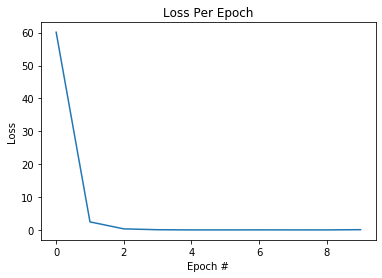

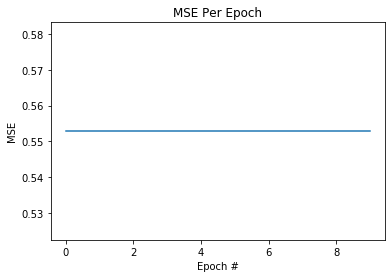

<Figure size 432x288 with 0 Axes>

In [140]:
sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TrainingLoss))
plt.title("Loss Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()
plt.clf()

sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TestingMSE))
plt.title("MSE Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("MSE")
plt.show()
plt.clf()

In [141]:
modelPerformance = []

for i, output in enumerate(zip(testOutput, predictedRatio)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Ratio" : target , "Predicted Ratio" : prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
modelPerformance.head()

,Example,True Ratio,Predicted Ratio
0,0,0.58,0
1,1,0.43,0
2,2,0.56,0
3,3,0.90,0
4,4,0.56,0


In [142]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputClassificationData, outputClassificationData, test_size=0.1)
testOutput = [i[0] for i in testOutput]

class PredictRedditPost(nn.Module):
    def __init__(self):
        super(PredictRedditPost, self).__init__()
        self.linearClassifier = nn.Sequential(nn.Linear(354, 64), nn.Dropout(0.5), nn.ReLU(),
                                              nn.Linear(64, 16), nn.ReLU(),
                                              nn.Linear(16, 1))
        self.sigmoid = nn.Sigmoid()
    def forward(self, featureVector):
        return self.sigmoid(self.linearClassifier(featureVector))

In [143]:
LR = 1e-3
WEIGHTDECAY=0.0005
EPOCH = 10

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = PredictRedditPost()
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHTDECAY)
BCEL = nn.BCELoss()

TestingAccuracy = []
TrainingLoss = []
for STEP in range(1, EPOCH + 1):
    epochLoss = 0
    model.train()
    
    for batchCount, data in enumerate(zip(trainInput, trainOutput)):
        handCraftedFeatures, postType = data

        handCraftedFeatures = torch.tensor(handCraftedFeatures)
        postType = torch.tensor(postType)

        handCraftedFeatures = handCraftedFeatures.to(device)
        postType = postType.to(device)

        predictedPostType = model(handCraftedFeatures)

        optimizer.zero_grad()
        Loss = BCEL(predictedPostType, postType)
        epochLoss = epochLoss + Loss.item()

        Loss.backward()
        optimizer.step()

    print("Epoch " + str(STEP) + " Loss: " + str(epochLoss / batchCount))
    TrainingLoss.append(epochLoss / batchCount)
    
    model.eval()
    testInput = torch.tensor(testInput)
    testInput = testInput.to(device)
    predictedPostType = torch.round(model(testInput))

    predictedPostType = [int(i[0]) for i in predictedPostType.tolist()]
    Accuracy = metrics.accuracy_score(testOutput, predictedPostType)
    print("Epoch "+ str(STEP) + "Accuracy: " + str(Accuracy) + "\n")
    TestingAccuracy.append(Accuracy)

Epoch 1 Loss: 0.6279305487384752
Epoch 1Accuracy: 0.9269662921348315

Epoch 2 Loss: 0.32553384251749096
Epoch 2Accuracy: 0.9382022471910112

Epoch 3 Loss: 0.326577007777279
Epoch 3Accuracy: 0.949438202247191

Epoch 4 Loss: 0.3072404589334687
Epoch 4Accuracy: 0.949438202247191

Epoch 5 Loss: 0.27576646584700487
Epoch 5Accuracy: 0.949438202247191

Epoch 6 Loss: 0.26750127004177787
Epoch 6Accuracy: 0.9438202247191011

Epoch 7 Loss: 0.31232581323684244
Epoch 7Accuracy: 0.9550561797752809

Epoch 8 Loss: 0.2944460986721264
Epoch 8Accuracy: 0.949438202247191

Epoch 9 Loss: 0.2763982310397323
Epoch 9Accuracy: 0.949438202247191

Epoch 10 Loss: 0.3014144834061419
Epoch 10Accuracy: 0.9550561797752809



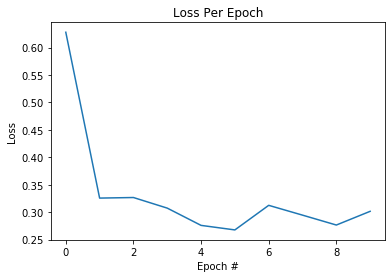

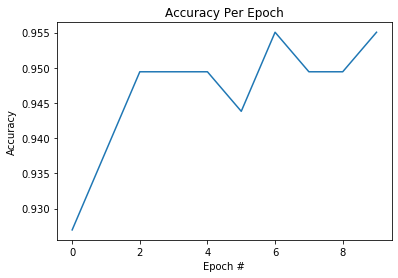

<Figure size 432x288 with 0 Axes>

In [144]:
sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TrainingLoss))
plt.title("Loss Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()
plt.clf()

sns.lineplot(x=np.array([x for x in range(EPOCH)]), y=np.array(TestingAccuracy))
plt.title("Accuracy Per Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.show()
plt.clf()

In [145]:
inputRegressionData = []
outputRegressionData = []

for tableRow in dataSet.iterrows():
    subReddit = tableRow[1]["subreddit"]
    SR_oneHotEncoding = subRedditOneHotEncoding["subReddit_" + subReddit].to_list()
    originalContent = tableRow[1]["is_oc"]
    nsfw = tableRow[1]["is_nsfw"]
    spoiler = tableRow[1]["is_spoiler"]
    post_type = tableRow[1]["post_type"]
    lenTitle = tableRow[1]["len_title"]
    titleSentiment = tableRow[1]["title_sentiment"]
    titleSubjectivity = tableRow[1]["title_subjectivity"]
    lenBody = tableRow[1]["len_body"]
    ratio = tableRow[1]["upvote_ratio"]

    inputRegressionData.append(SR_oneHotEncoding + [lenTitle, titleSentiment, titleSubjectivity, lenBody, originalContent, nsfw, spoiler, post_type])
    outputRegressionData.append([ratio])

In [146]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputRegressionData, outputRegressionData, test_size=0.1)
ratioRegression = Lasso().fit(np.array(trainInput), np.array(trainOutput)) #Works better with sparse data
predictedOutput = ratioRegression.predict(np.array(testInput))

modelPerformance = []

testOutput = [i[0] for i in testOutput]
predictedOutput = predictedOutput.tolist()
for i, output in enumerate(zip(testOutput, predictedOutput)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Ratio" : target , "Predicted Ratio" : prediction, "Residual" : target - prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
MSE = metrics.mean_squared_error(testOutput, predictedOutput)
averageResidual = np.mean(modelPerformance["Residual"])

modelPerformance.head()

,Example,True Ratio,Predicted Ratio,Residual
0,0,0.50,0.706451,-0.206451
1,1,0.94,0.757291,0.182709
2,2,0.50,0.757291,-0.257291
3,3,0.95,0.757291,0.192709
4,4,0.90,0.757291,0.142709


In [147]:
print("Mean Squared Error: " + str(MSE))
print("Average Residual: " + str(averageResidual))

Mean Squared Error: 0.0375707529038548
Average Residual: 0.005729083003555082


In [148]:
inputClassificationData = []
outputClassificationData = []

for tableRow in dataSet.iterrows():
    subReddit = tableRow[1]["subreddit"]
    SR_oneHotEncoding = subRedditOneHotEncoding["subReddit_" + subReddit].to_list()
    originalContent = tableRow[1]["is_oc"]
    nsfw = tableRow[1]["is_nsfw"]
    spoiler = tableRow[1]["is_spoiler"]
    lenTitle = tableRow[1]["len_title"]
    titleSentiment = tableRow[1]["title_sentiment"]
    titleSubjectivity = tableRow[1]["title_subjectivity"]
    lenBody = tableRow[1]["len_body"]
    ratio = tableRow[1]["upvote_ratio"]
    post_type = tableRow[1]["post_type"]

    inputClassificationData.append(SR_oneHotEncoding + [lenTitle, titleSentiment, titleSubjectivity, lenBody, originalContent, nsfw, spoiler, ratio])
    outputClassificationData.append([post_type])

In [149]:
trainInput, testInput, trainOutput, testOutput = train_test_split(inputClassificationData, outputClassificationData, test_size=0.1)
ratioRegression = LogisticRegression().fit(np.array(trainInput), np.array(trainOutput))
predictedOutput = ratioRegression.predict(np.array(testInput))
modelPerformance = []

testOutput = [i[0] for i in testOutput]
predictedOutput = predictedOutput.tolist()

for i, output in enumerate(zip(testOutput, predictedOutput)):
    target, prediction = output
    modelPerformance.append({"Example" : i, "True Class" : target , "Predicted Class" : prediction})
    
modelPerformance = pd.DataFrame(modelPerformance)
modelPerformance.head()

,Example,True Class,Predicted Class
0,0,1.0,1.0
1,1,1.0,1.0
2,2,1.0,1.0
3,3,0.0,0.0
4,4,1.0,1.0


In [150]:
Accuracy = metrics.accuracy_score(testOutput, predictedOutput)
print("Accuracy: " + str(Accuracy))

Accuracy: 0.9831460674157303
